In [90]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from tqdm import tqdm

# Metropolis-Hasting - One dimension

# Background
1. Assume we know the target function which is the gaussian distribution $N(\mu, \sigma^2)$
2. However, we only know the standard derivation $\sigma$, but not the mean $\mu$, so $\mu$ is equivalent to $\theta$
3. We want to estimate the $p(\mu|\sigma, \text{data})$ by mcmc

### Define all settings
1. Assume true $\mu$ and true $\sigma$ first, so we can generate our samples (equivalent to our observation in practice)
2. Step size define the proposal distribution, and this is the only hyperparamters in this model 
3. MCMC dropout will remove first x% of samples, as they are just burn-in state in markov chains

### Target Function
- Parameters in this function is what we want to estiamte
- E.g. if we are running a factor models, $f(x)=ax+by+c$, where $a,b,c$ are the model parameters to estimate in this exercise
- $f(x|\mu, \sigma) = N(\mu, \sigma)$

### Proposal Function
- Function to propose next value given current value
- This follows Markov Chain properties, as it only depends on last value
- For simplicity, we use normal distribution in this excerise (symmetric such that $p(x_{t+1}|x_t) = p(x_t|x_{t+1})$)
- $x_{t+1} = x_t + N(0, \text{step})$

### Prior Mean
- Define the prior distribution of the parameters
- It could be any distribution, we can even ignore it, as the divison of two uniform distribution are always 1
- i.e. $p(\mu)$
- e.g. if we only know the boundary of $\theta$, we can define a uniform distribution with this boundary, so everything outside will have zero probability

### Log Likelihood Function
- Likelihood of proposed $\theta$ given observation
- The reason of using log is that likelihood could be very samll that python couldn't evaluate
- $p(\text{data}|\theta)$

### Acceptance ratio
- $a = \frac{p(x_{t+1})p(\text{data}|x_{t+1})}{p(x_t)p(\text{data}|x_t)} \frac{g(x_{t+1}|x_t)}{g(x_{t}|x_{t+1})}$
- If proposal function is symmetric then $a = \frac{p(x_{t+1})p(\text{data}|x_{t+1})}{p(x_t)p(\text{data}|x_t)}$
- Because we use log likelihood: $\frac{p(\text{data}|x_{t+1})}{p(\text{data}|x_t)} = \exp(\log(p(\text{data}|x_{t+1})) - \log(p(\text{data}|x_t))$

In [201]:
true_mean = -5
true_std = 50
sample_size = 10000
step_size = 0.5
mcmc_dropout = 0.1
mcmc_iter = 1000
x_cur = -10

def target_func(mean, std):
    return scipy.stats.norm(loc=mean, scale=std)

def proposal_func(x, step_size):
    return x + np.random.normal(0, step_size)

def prior_mean():
    return scipy.stats.uniform(loc=-1e5, scale=2e5)

def log_likelihood(mean, std, data):    
    return np.sum(np.log(target_func(mean, std).pdf(data)))    

In [202]:
samples = target_func(true_mean, true_std).rvs(sample_size)

x_markov_chains = []

pbar = tqdm(total=mcmc_iter, position=0, leave=True)
for i in range(mcmc_iter):
    x_new = proposal_func(x_cur, step_size)
    
    new_likelihood = log_likelihood(x_new, true_std, samples)
    new_prior = prior_mean().pdf(x_new)
    
    cur_likelihood = log_likelihood(x_cur, true_std, samples)
    cur_prior = prior_mean().pdf(x_cur)
    
    acceptance_ratio = new_prior/cur_prior * np.exp(new_likelihood-cur_likelihood)
    acceptance_ratio = min(acceptance_ratio, 1)
    alpha = np.random.uniform(0,1)
    
    if alpha < acceptance_ratio:
        x_cur = x_new
    
    x_markov_chains.append(x_cur)     
    pbar.update(1)
pbar.close()  

100%|██████████████████████████████████████| 1000/1000 [00:01<00:00, 816.60it/s]


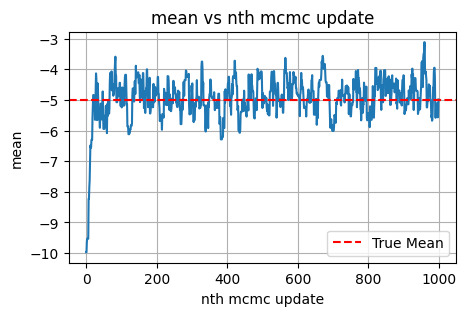

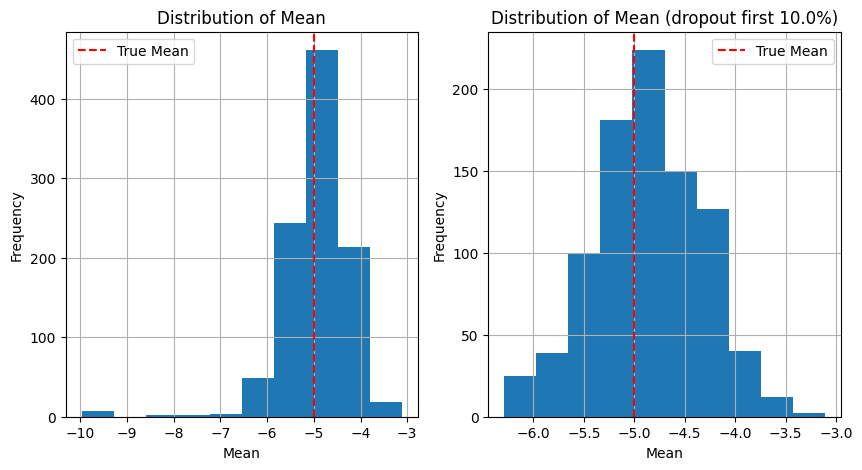

In [203]:
plt.figure(figsize=(5,3))
plt.plot(x_markov_chains)
plt.axhline(true_mean, label="True Mean", color="red", linestyle="--")
plt.xlabel("nth mcmc update")
plt.ylabel("mean")
plt.title("mean vs nth mcmc update")
plt.grid()
plt.legend()
plt.show()

fig, axs = plt.subplots(1,2, figsize=(10,5))
ax = axs[0]
ax.hist(x_markov_chains)
ax.axvline(true_mean, label="True Mean", color="red", linestyle="--")
ax.set_xlabel("Mean")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of Mean")
ax.legend()
ax.grid()

ax = axs[1]
ax.hist(x_markov_chains[int(len(x_markov_chains)*mcmc_dropout):])
ax.axvline(true_mean, label="True Mean", color="red", linestyle="--")
ax.set_xlabel("Mean")
ax.set_ylabel("Frequency")
ax.set_title(f'Distribution of Mean (dropout first {mcmc_dropout*100}%)')
ax.legend()
ax.grid()
plt.show()

# Metropolis-Hasting - Multi dimension
- Unknown mean and standard derivation

## Method 1 - Joint distribution
- Define joint distribution for proposal function and prior distribution, <b>we update all parameters in once in each iteration</b>
- Proposal Function = Multivariate Normal Distribution
- Prior Distribution = Join distribution of mean and std, std has no negative values, so $P(\sigma \lt 0|\text{data}, \mu) = 0$
- I just use the the mutiple of two prior as join distribution, as I assume they are independent, and they don't need normalization (i.e. $\int\int p(\mu, \sigma) d\mu d\sigma = 1$) as we care about ratio only

In [348]:
true_mean = -10
true_std = 0.5
sample_size = 10000
step_size_x = 0.5
step_size_s = 0.01
mcmc_dropout = 0.1
mcmc_iter = 1000

x_cur = 0
s_cur = 1

def target_func(mean, std):
    return scipy.stats.norm(loc=mean, scale=std)

def proposal_func(x1, x2, step_size_x1, step_size_x2):
    delta = scipy.stats.multivariate_normal([0,0], cov=[[step_size_x1, 0], [0, step_size_x2]]).rvs(1)
    return x1 + delta[0], x2 + delta[1]            

def prior_mean():
    return scipy.stats.uniform(loc=-1e5, scale=2e5)

def prior_std():
    return scipy.stats.uniform(loc=0, scale=2e5)

def log_likelihood(mean, std, data):    
    return np.sum(np.log(target_func(mean, std).pdf(data)))   

In [349]:
samples = target_func(true_mean, true_std).rvs(sample_size)

x_markov_chains = []
s_markov_chains = []

pbar = tqdm(total=mcmc_iter, position=0, leave=True)
for i in range(mcmc_iter):
    x_new, s_new = proposal_func(x_cur, s_cur, step_size_x, step_size_s)        
    
    new_likelihood = log_likelihood(x_new, s_new, samples)
    new_prior = prior_mean().pdf(x_new) * prior_std().pdf(s_new)
    
    cur_likelihood = log_likelihood(x_cur, s_cur, samples)
    cur_prior = prior_mean().pdf(x_cur) * prior_std().pdf(s_cur)
        
    acceptance_ratio = new_prior/cur_prior * np.exp(new_likelihood-cur_likelihood)                    
    acceptance_ratio = min(acceptance_ratio, 1)
    alpha = np.random.uniform(0,1)
    
    if alpha < acceptance_ratio:
        x_cur = x_new
        s_cur = s_new
    
    x_markov_chains.append(x_cur)     
    s_markov_chains.append(s_cur) 
    
    pbar.update(1)
pbar.close() 

  0%|                                | 0/1000 [00:00<?, ?it/s]/var/folders/gc/9_k6gnkd55z7pygnczhgy5km0000gn/T/ipykernel_24221/4202603096.py:16: RuntimeWarning: overflow encountered in exp
  acceptance_ratio = new_prior/cur_prior * np.exp(new_likelihood-cur_likelihood)
100%|████████████████████| 1000/1000 [00:01<00:00, 543.96it/s]


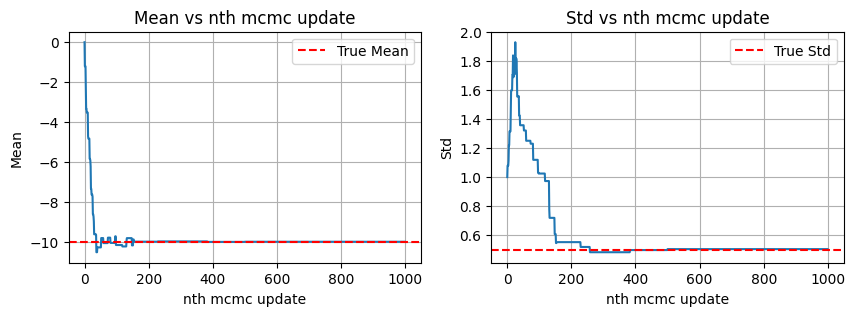

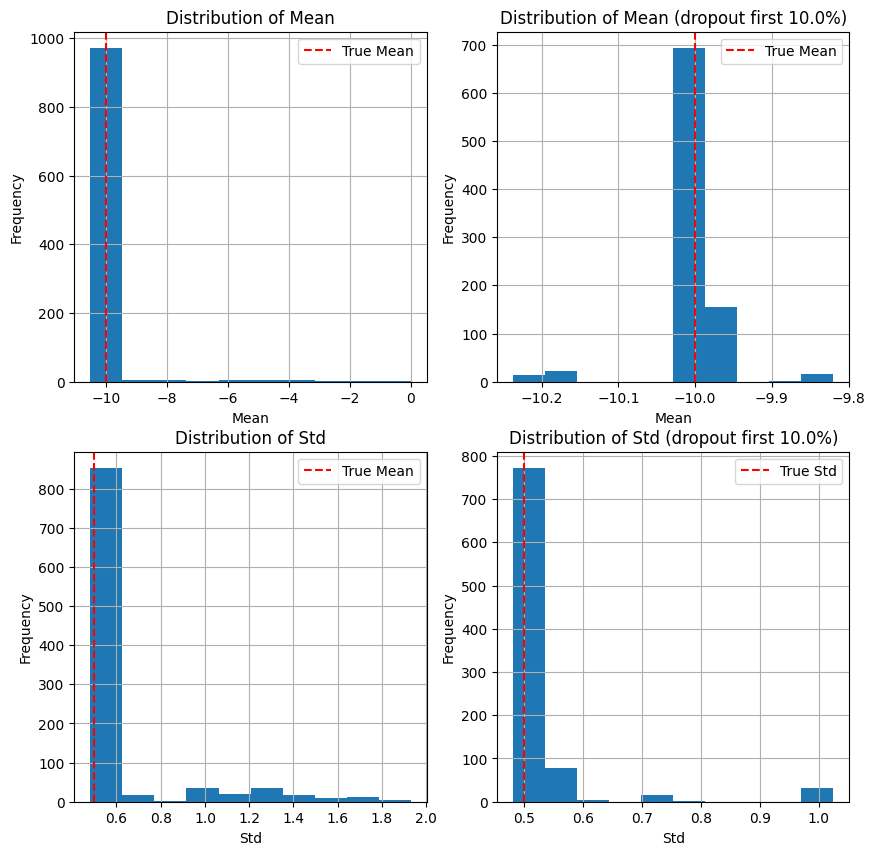

In [350]:
fig, axs = plt.subplots(1,2,figsize=(10,3))
ax = axs[0]
ax.plot(x_markov_chains)
ax.axhline(true_mean, label="True Mean", color="red", linestyle="--")
ax.set_xlabel("nth mcmc update")
ax.set_ylabel("Mean")
ax.set_title("Mean vs nth mcmc update")
ax.grid()
ax.legend()

ax = axs[1]
ax.plot(s_markov_chains)
ax.axhline(true_std, label="True Std", color="red", linestyle="--")
ax.set_xlabel("nth mcmc update")
ax.set_ylabel("Std")
ax.set_title("Std vs nth mcmc update")
ax.grid()
ax.legend()

fig, axs = plt.subplots(2,2, figsize=(10,10))
ax = axs[0][0]
ax.hist(x_markov_chains)
ax.axvline(true_mean, label="True Mean", color="red", linestyle="--")
ax.set_xlabel("Mean")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of Mean")
ax.legend()
ax.grid()

ax = axs[0][1]
ax.hist(x_markov_chains[int(len(x_markov_chains)*mcmc_dropout):])
ax.axvline(true_mean, label="True Mean", color="red", linestyle="--")
ax.set_xlabel("Mean")
ax.set_ylabel("Frequency")
ax.set_title(f'Distribution of Mean (dropout first {mcmc_dropout*100}%)')
ax.legend()
ax.grid()

ax = axs[1][0]
ax.hist(s_markov_chains)
ax.axvline(true_std, label="True Mean", color="red", linestyle="--")
ax.set_xlabel("Std")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of Std")
ax.legend()
ax.grid()

ax = axs[1][1]
ax.hist(s_markov_chains[int(len(s_markov_chains)*mcmc_dropout):])
ax.axvline(true_std, label="True Std", color="red", linestyle="--")
ax.set_xlabel("Std")
ax.set_ylabel("Frequency")
ax.set_title(f'Distribution of Std (dropout first {mcmc_dropout*100}%)')
ax.legend()
ax.grid()
plt.show()

## Method 2 - Conditional probability
- Run mcmc update for each parameters while keeping other parameters as constant
- No joint distribution concept for prior and proposal function

In [351]:
true_mean = -10
true_std = 0.5
sample_size = 10000
step_size_x = 0.5
step_size_s = 0.01
mcmc_dropout = 0.1
mcmc_iter = 1000

x_cur = 0
s_cur = 1

def target_func(mean, std):
    return scipy.stats.norm(loc=mean, scale=std)

def proposal_func(x, step_size):
    return x + np.random.normal(0, step_size)           

def prior_mean():
    return scipy.stats.uniform(loc=-1e5, scale=2e5)

def prior_std():
    return scipy.stats.uniform(loc=0, scale=2e5)

def log_likelihood(mean, std, data):    
    return np.sum(np.log(target_func(mean, std).pdf(data)))  

In [352]:
samples = target_func(true_mean, true_std).rvs(sample_size)

x_markov_chains = []
s_markov_chains = []

pbar = tqdm(total=mcmc_iter, position=0, leave=True)
for i in range(mcmc_iter):
    
    # mcmc update mean, assuming std is constant     
    x_new = proposal_func(x_cur, step_size_x)
    
    new_likelihood = log_likelihood(x_new, s_cur, samples)
    new_prior = prior_mean().pdf(x_new)
    
    cur_likelihood = log_likelihood(x_cur, s_cur, samples)
    cur_prior = prior_mean().pdf(x_cur) * prior_std().pdf(s_cur)
    
    acceptance_ratio = new_prior/cur_prior * np.exp(new_likelihood-cur_likelihood)
    acceptance_ratio = min(acceptance_ratio, 1)
    alpha = np.random.uniform(0,1)
    
    if alpha < acceptance_ratio:
        x_cur = x_new
        
    x_markov_chains.append(x_cur)     
    
    # mcmc update std assuming mean is constant
    s_new = proposal_func(s_cur, step_size_s)
    
    new_likelihood = log_likelihood(x_cur, s_new, samples)
    new_prior = prior_std().pdf(s_new)
    
    cur_likelihood = log_likelihood(x_cur, s_cur, samples)
    cur_prior = prior_std().pdf(s_cur)
    
    acceptance_ratio = new_prior/cur_prior * np.exp(new_likelihood-cur_likelihood)
    acceptance_ratio = min(acceptance_ratio, 1)
    alpha = np.random.uniform(0,1)
    
    if alpha < acceptance_ratio:
        s_cur = s_new
        
    s_markov_chains.append(s_cur)         
    pbar.update(1)
pbar.close() 

  0%|                                | 0/1000 [00:00<?, ?it/s]/var/folders/gc/9_k6gnkd55z7pygnczhgy5km0000gn/T/ipykernel_24221/3057541611.py:18: RuntimeWarning: overflow encountered in exp
  acceptance_ratio = new_prior/cur_prior * np.exp(new_likelihood-cur_likelihood)
/var/folders/gc/9_k6gnkd55z7pygnczhgy5km0000gn/T/ipykernel_24221/3057541611.py:36: RuntimeWarning: overflow encountered in exp
  acceptance_ratio = new_prior/cur_prior * np.exp(new_likelihood-cur_likelihood)
100%|████████████████████| 1000/1000 [00:02<00:00, 371.45it/s]


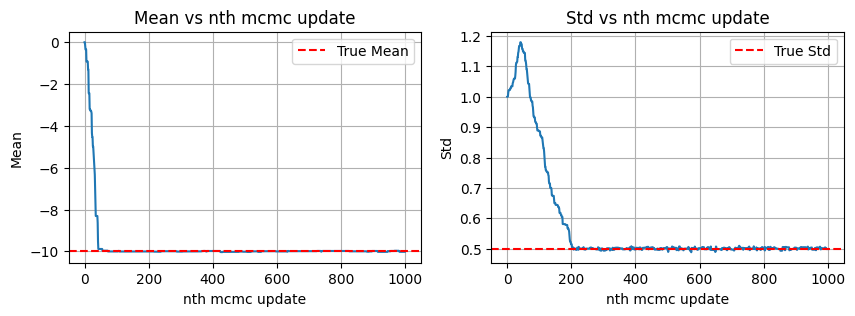

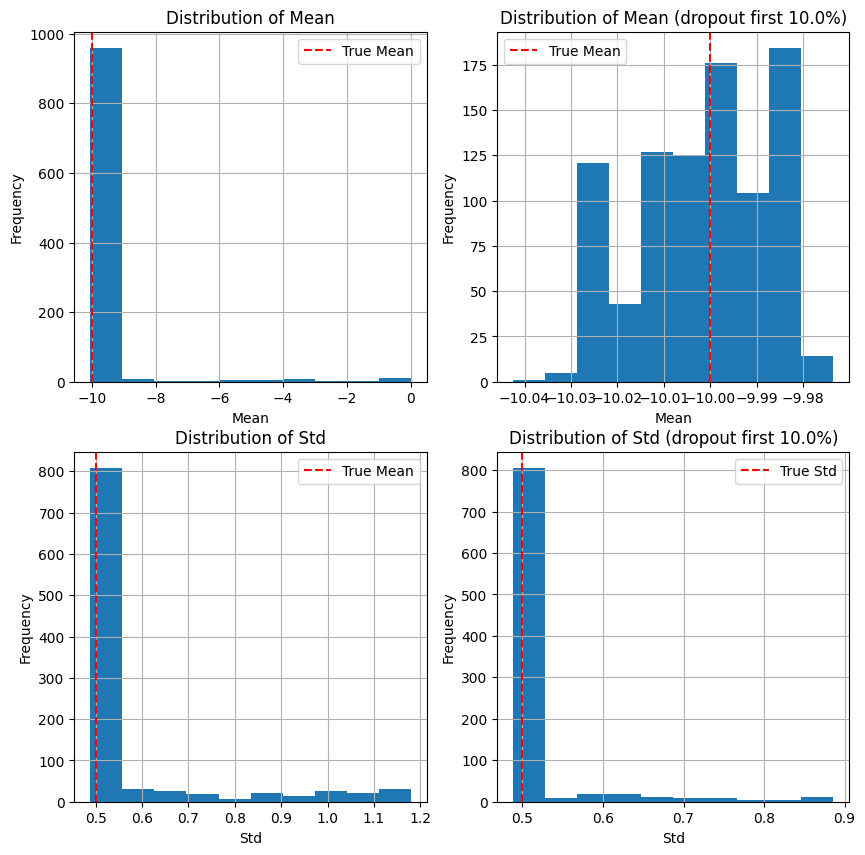

In [353]:
fig, axs = plt.subplots(1,2,figsize=(10,3))
ax = axs[0]
ax.plot(x_markov_chains)
ax.axhline(true_mean, label="True Mean", color="red", linestyle="--")
ax.set_xlabel("nth mcmc update")
ax.set_ylabel("Mean")
ax.set_title("Mean vs nth mcmc update")
ax.grid()
ax.legend()

ax = axs[1]
ax.plot(s_markov_chains)
ax.axhline(true_std, label="True Std", color="red", linestyle="--")
ax.set_xlabel("nth mcmc update")
ax.set_ylabel("Std")
ax.set_title("Std vs nth mcmc update")
ax.grid()
ax.legend()

fig, axs = plt.subplots(2,2, figsize=(10,10))
ax = axs[0][0]
ax.hist(x_markov_chains)
ax.axvline(true_mean, label="True Mean", color="red", linestyle="--")
ax.set_xlabel("Mean")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of Mean")
ax.legend()
ax.grid()

ax = axs[0][1]
ax.hist(x_markov_chains[int(len(x_markov_chains)*mcmc_dropout):])
ax.axvline(true_mean, label="True Mean", color="red", linestyle="--")
ax.set_xlabel("Mean")
ax.set_ylabel("Frequency")
ax.set_title(f'Distribution of Mean (dropout first {mcmc_dropout*100}%)')
ax.legend()
ax.grid()

ax = axs[1][0]
ax.hist(s_markov_chains)
ax.axvline(true_std, label="True Mean", color="red", linestyle="--")
ax.set_xlabel("Std")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of Std")
ax.legend()
ax.grid()

ax = axs[1][1]
ax.hist(s_markov_chains[int(len(s_markov_chains)*mcmc_dropout):])
ax.axvline(true_std, label="True Std", color="red", linestyle="--")
ax.set_xlabel("Std")
ax.set_ylabel("Frequency")
ax.set_title(f'Distribution of Std (dropout first {mcmc_dropout*100}%)')
ax.legend()
ax.grid()
plt.show()